# Rigol Waveform Capture
by Josiah Sinclair

This notebook should be used to capture waveforms from an oscilloscope which is running in auto trigger mode. 
The settings which were used while creating the notebook were
Sample Rate: 250 MSa/s
Memory Depth: 3K
X-scale: 500 ns

In [54]:
# Import useful Python packages
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pyvisa as visa
import time
import sys

In [55]:
# Connect to the oscilloscope
# This should work if you only have a single Rigol oscilloscope connected by USB to your computer
# I have only tested this with a Rigol DS1054Z
rm = visa.ResourceManager()
# Get the USB device, e.g. 'USB0::0x1AB1::0x0588::DS1ED141904883'
instruments = rm.list_resources()
usb = list(filter(lambda x: 'USB' in x, instruments))
if len(usb) != 1:
    print('Bad instrument list', instruments)
    sys.exit(-1)
print(usb[0])
scope = rm.open_resource(usb[0], timeout=25e1, chunk_size=1024000)
print(scope.query('*IDN?'))

USB0::0x1AB1::0x04CE::DS1ZA231602198::INSTR
RIGOL TECHNOLOGIES,DS1054Z,DS1ZA231602198,00.04.04.SP4



In [108]:
# Query your scope to see what the acquisition parameters are.
# You can also select the "Acquire" button on the scope to display or change these.
SAMPRATE = float(scope.query(':ACQuire:SRATe?'))
MEMDEPTH = scope.query(':ACQ:MDEP?')
XSCALE = float(scope.query(':TIM:MAIN:SCAL?'))
print('Sample rate is %1.1f' %SAMPRATE)
print("Memory depth is", MEMDEPTH, "samples")
print("X-scale is %1.1f ns"%(1e9*XSCALE))
# You will want to set Sample Rate * 12 * xscale to be as close as possible to the memory depth in the subsequent cell.
# if SAMPRATE*12*XSCALE > MEMDEPTH:increase MEMDEPTH
# if SAMPRATE*12*XSCALE < MEMDEPTH: increase MEMDEPTH
print('SAMPRATE*12*XSCALE is %1.1f' %(SAMPRATE*12*XSCALE))
# adjust memory depth accordingly

Sample rate is 250000000.0
Memory depth is 3000
 samples
X-scale is 500.0 ns
SAMPRATE*12*XSCALE is 1500.0


In [113]:
# Set the size of the waveform. This can be 3K, 30K, 300K, 3M, or 6M
Mem_depth = 3000 
scope.write(":ACQ:MDEP " + str(Mem_depth))

16

In [119]:
# Initialize the scope with the right settings for data acquisition
# Some explanation of what the settings do.
# :WAV:MODE RAW read the data in the internal memory if the scope is stopped
# :WAV:MODE NORM reads the waveform data on the screen,
# :WAV:MODE MAX read the data on the screen if the scope is running, if the scope is stopped, it reads the internal memory
# So what I am seeing is that RAW, NORM, MAX all return 1200 points if the scope is running.
# If the scope is stopped, with a 3 second sleep, NORM still returns 1200 points, but RAW and MAX returns more.
scope.write(":WAV:MODE RAW")
scope.write(":WAV:FORM BYTE")
scope.write(":STOP")
time.sleep(.2)  # Without a sleep of about 0.2 s I get a timeout error
scope.write(":WAV:STAR " + str(0))
scope.write(":WAV:STOP " + str(Mem_depth))
scope.write(":WAV:DATA? CHAN1")  # Request the data
unbuffered_data = scope.read_raw()
rawdata = np.frombuffer(unbuffered_data, 'B')[11:-1]
print(len(rawdata))
scope.write(":RUN")

3000


6

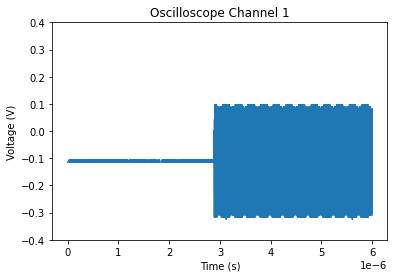

In [120]:
# Alright. Congrats. You got your data, now what are you going to do with it?
# The first thing to do is convert it from binary into useful numbers and get an x axis.
# Get the timescale
dt = 12*XSCALE/Mem_depth # alternatively #float(scope.query(":WAVeform:XINCrement?"))
# Get the voltage scale
voltscale = float(scope.query(':CHAN1:SCAL?'))
# print("Voltscale is", voltscale)
# Get the voltage offset
voltoffset = float(scope.query(":CHAN1:OFFS?"))
# print("Voltoffset is", voltoffset)

# Walk through the data, and map it to actual voltages
# This mapping is from Josiah Sinclair 2021/07/30
# Data is in Binary, shift by 256/2=128, then scale by 10 times the voltscale to get the actual voltage, then shift by the voltoffset
data = (rawdata - 121.1) * 10 * voltscale / 256 - voltoffset
# Now, generate a time axis.
t = np.arange(0, dt * (len(data)), dt)

# Plot the data (optional)
plt.figure()
plt.plot(t, data)
plt.title("Oscilloscope Channel 1")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (s)")
plt.ylim(-2 * voltscale, 2 * voltscale)
plt.show()